# Project 1 Notebook
## Project members: Andrew, Tim, Mide

## Feel free to change/add cells as needed
## If you are going to make a function try to let each other know that you made a function so we can all use it. (Just incase)

## Points to hit:
* Point 1: Correlation between highest grossing movies and critic/user ratings
* Point 2: Correlation between the rating of a movie and the total gross
* Point 3: Correlation between movie genres and total gross
---

## Import needed packages for project
---

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

sns.set_theme(style='darkgrid')

%matplotlib inline

# Creating the Master Dataframe
---

#Drop null values from Rotten Tomatoes
rt_movie_info.dropna(subset=['box_office'], inplace = True)

#Create a dataframe to clean
rt_new = rt_movie_info[['rating' , 'box_office' , 'genre', 'director']].copy()

#Cleaning the new dataframe
rt_new.dropna(subset=['director'], inplace = True)
rt_new['box_office'] = rt_new['box_office'].str.replace(',' , '')

#cast box office to type int from object
rt_new['box_office'] = rt_new['box_office'].astype(int)

#save cleaned master dataframe
rt_new.to_csv('master.csv', encoding='utf-8', index=False)

In [3]:
master = pd.read_csv('data/master.csv')

## Selecting Dataset for point 1
---

In [4]:
#creating dataframe with director and box office
d_earning = master[['director', 'box_office']]
d_earning.groupby(['director']).sum().reset_index()
d_earning.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)

#create separate dataframe with top 20 earning directors
top20_d_earning = d_earning[:20]
top20_d_earning['box_office'] = top20_d_earning['box_office'].apply(lambda x: x/1000000)
top20_d_earning

,director,box_office
0,Mel Gibson,368.000000
1,Peter Jackson,303.001229
2,Sam Mendes,299.300000
3,Jay Roach,279.167575
4,Chris Columbus,261.835892
5,Joel Zwick,241.250669
6,Steven Spielberg,234.141872
7,Peter Berg,227.946274
8,Bryan Singer,214.813155
9,Justin Lin,209.805005


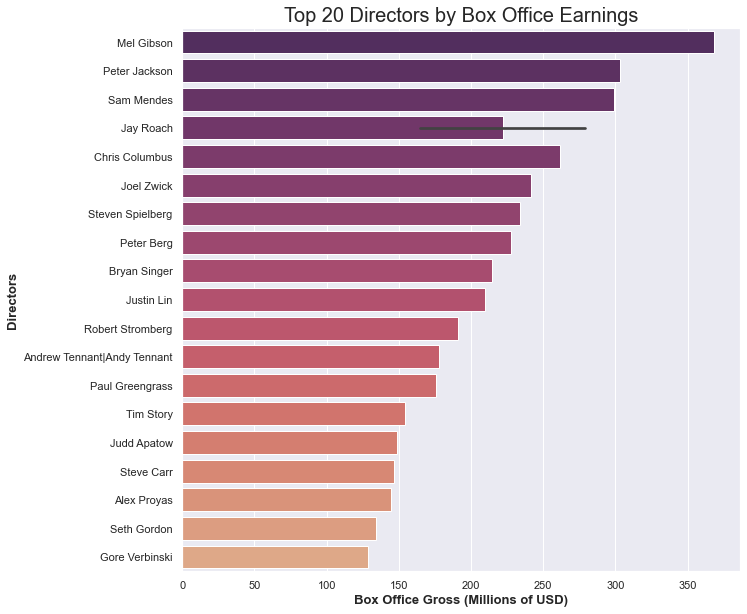

In [5]:
#create plot
fig, ax = plt.subplots(figsize=(10,10))

#plot top 20 data onto a bar plot
sns.barplot(y='director',x='box_office', orient='h', palette= 'flare_r',  data= top20_d_earning)
#setting title and labels
ax.set_title('Top 20 Directors by Box Office Earnings', fontsize = 20)
ax.set_ylabel('Directors', fontsize = 13, weight = 'bold')
ax.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold');

## Selected Dataset for point 2
---

### Isolate columns for my visualization

In [6]:
rating_gross = master[['rating', 'box_office']]

### Drop the irrelevant columns

In [7]:
rating_gross.drop(rating_gross[rating_gross['rating'] == 'NR'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'NC17'].index, inplace=True)
rating_gross.drop(rating_gross[rating_gross['rating'] == 'G'].index, inplace=True)

### Use lambda function to display currency ticks properly

In [8]:
rating_gross['box_office'] = rating_gross['box_office'].apply(lambda x: x/1000000)

### Visualize

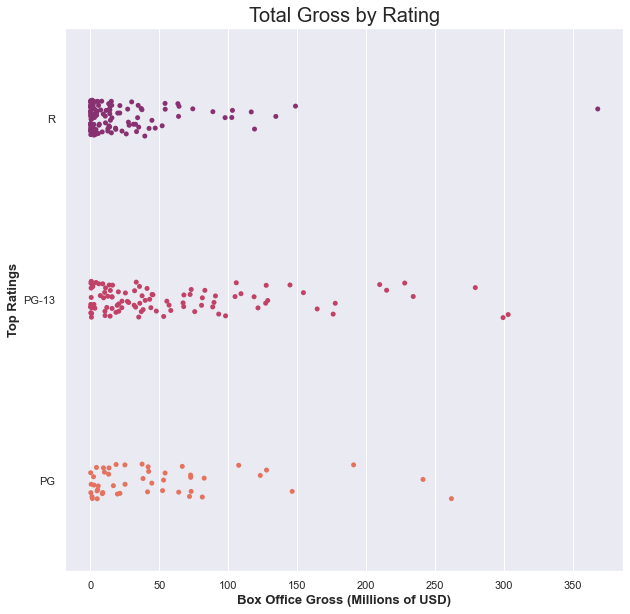

In [9]:
f, ax = plt.subplots(figsize=(10, 10))

sns.stripplot(x="box_office", y="rating", data=rating_gross, palette= 'flare_r')

ax.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold')
ax.set_ylabel('Top Ratings', fontsize = 13, weight = 'bold')
ax.set_title('Total Gross by Rating', fontsize = 20);

## Selecting Dataset for point 3
---

### Filtering down dataset to top 20 

In [15]:
#create dataframe with genre and box office
g_gross = master[['genre', 'box_office']]

#group by box office, calculate sum of box office and sort by box office
aggregation_functions = {'box_office': 'sum'}
df = g_gross.groupby(g_gross['genre']).aggregate(aggregation_functions).reset_index()
df.sort_values('box_office', inplace=True, ascending=False, ignore_index=True)

#create dataframe of top 20 by genre
g_gross_20 = df[:20]
g_gross_20['box_office'] = g_gross_20['box_office'].apply(lambda x: x/1000000)

### Visualize

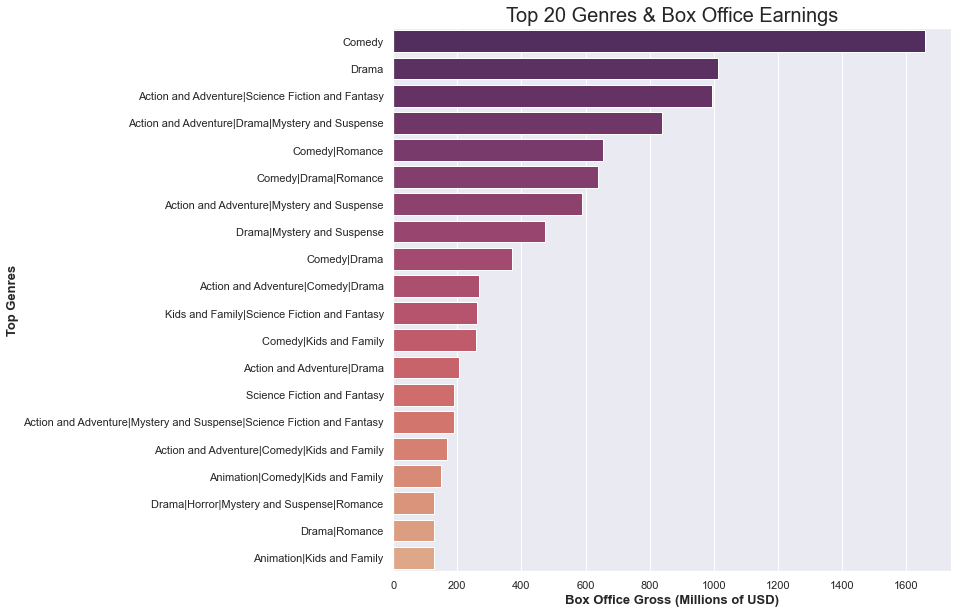

In [16]:
fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(y =g_gross_20['genre'].head(20),x = g_gross_20['box_office'], orient = 'h', palette = 'flare_r')

ax.set_title('Top 20 Genres & Box Office Earnings', fontsize =  20)
ax.set_xlabel('Box Office Gross (Millions of USD)', fontsize = 13, weight = 'bold')
ax.set_ylabel('Top Genres', fontsize = 13, weight = 'bold');